In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
data_dir = "/kaggle/input/datasets/anyta1712/emotions"

Device: cuda


In [4]:
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

train_dataset = datasets.ImageFolder(train_dir, transform=base_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=base_transform)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
# Кастомный Dataset для генерации аугментированных изображений
class AugmentedDataset(Dataset):
    def __init__(self, img_paths, label, transform):
        self.img_paths = img_paths
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        # аугментация
        img = self.transform(img)
        return img, self.label

#добавляем аугментированные изображения к тем классам, где данных меньше
datasets_to_concat = [train_dataset]
for class_idx, count in enumerate(class_counts):    
    if count < max_count:
        needed = max_count - count
        class_samples = [s[0] for s in train_dataset.samples if s[1] == class_idx]
        aug_imgs = [random.choice(class_samples) for _ in range(needed)]
        datasets_to_concat.append(
            AugmentedDataset(aug_imgs, class_idx, augment_transform)
        )

# Объединяем оригинальный датасет и все аугментированные датасеты
balanced_train_dataset = ConcatDataset(datasets_to_concat)
# Создаем DataLoader для обучения
train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
# DataLoader для теста (без аугментаций)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Выводим итоговый размер обучающего датасета
print("Balanced train dataset size:", len(balanced_train_dataset))

Balanced train dataset size: 50505


In [8]:
# загружаем предобученную модель ResNet50 (обученную на ImageNet)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# получаем количество входных признаков последнего слоя
num_features = model.fc.in_features
# заменяем последний слой 
model.fc = nn.Sequential(
    nn.Dropout(0.5),              
    nn.Linear(num_features, 256),
    nn.ReLU(),                    
    nn.BatchNorm1d(256),          
    nn.Dropout(0.3),              
    nn.Linear(256, num_classes)  
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


In [9]:
#  Loss + Optimizer
class_weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float)
class_weights = class_weights / class_weights.sum() * num_classes
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [10]:
# Train and Evaluate
def train_model(model, loader):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # считаем метрики качества
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return total_loss/len(loader), acc, precision, recall, f1

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # считаем метрики качества
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return acc, precision, recall, f1, all_labels, all_preds

In [11]:
# Training Loop
epochs = 15
for epoch in range(epochs):
    loss, train_acc, train_prec, train_rec, train_f1 = train_model(model, train_loader)
    test_acc, test_prec, test_rec, test_f1, y_true, y_pred = evaluate(model, test_loader)
    scheduler.step(test_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {loss:.4f} | Acc: {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f}")
    print(f"Test Acc: {test_acc:.4f} | Prec: {test_prec:.4f} | Rec: {test_rec:.4f} | F1: {test_f1:.4f}")
    print("-"*50)

Epoch 1/15
Train Loss: 0.7525 | Acc: 0.5097 | Prec: 0.4974 | Rec: 0.5097 | F1: 0.4812
Test Acc: 0.5847 | Prec: 0.6121 | Rec: 0.5847 | F1: 0.5893
--------------------------------------------------
Epoch 2/15
Train Loss: 0.5156 | Acc: 0.6327 | Prec: 0.6212 | Rec: 0.6327 | F1: 0.6206
Test Acc: 0.6199 | Prec: 0.6456 | Rec: 0.6199 | F1: 0.6169
--------------------------------------------------
Epoch 3/15
Train Loss: 0.4453 | Acc: 0.6764 | Prec: 0.6682 | Rec: 0.6764 | F1: 0.6689
Test Acc: 0.6486 | Prec: 0.6607 | Rec: 0.6486 | F1: 0.6490
--------------------------------------------------
Epoch 4/15
Train Loss: 0.3938 | Acc: 0.7087 | Prec: 0.7023 | Rec: 0.7087 | F1: 0.7032
Test Acc: 0.6527 | Prec: 0.6652 | Rec: 0.6527 | F1: 0.6531
--------------------------------------------------
Epoch 5/15
Train Loss: 0.3480 | Acc: 0.7415 | Prec: 0.7373 | Rec: 0.7415 | F1: 0.7380
Test Acc: 0.6583 | Prec: 0.6613 | Rec: 0.6583 | F1: 0.6581
--------------------------------------------------
Epoch 6/15
Train Los

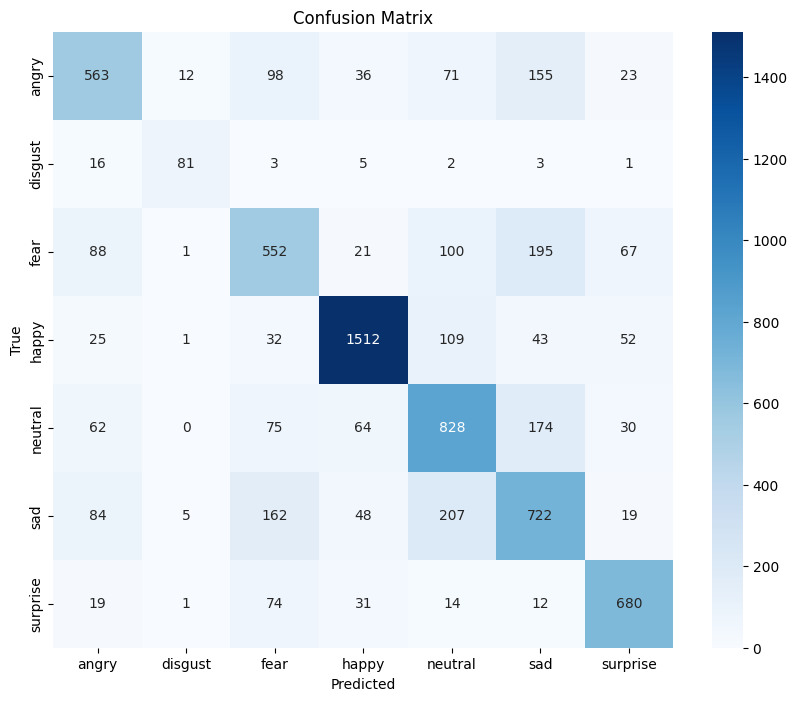

In [12]:
# 9. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [13]:
# 10. Save Model
torch.save(model.state_dict(), "emotion_resnet50_balanced.pth")
print("Model saved as emotion_resnet50_balanced.pth")

Model saved as emotion_resnet50_balanced.pth
